In [1]:
import pandas as pd
import os
import pyarrow.parquet as pq
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.models import resnet50, resnet18

In [2]:
def get_batch(batchfile):
    batch1 = pq.ParquetFile(batchfile)
    it = batch1.iter_batches()
    batch1 = next(it).to_pandas()
    batch1['Batch'] = batchfile.split('/')[-1].split('batch_')[1].split('.')[0]
    return(batch1)

def get_pq(pqfile):
    pq_df = pq.ParquetFile(pqfile)
    it = pq_df.iter_batches()
    pq_df = next(it).to_pandas()
    return(pq_df)

In [3]:
sensor = pd.read_csv('/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
train_meta = pq.ParquetFile('/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train_meta.parquet')
it = train_meta.iter_batches()
train_meta = next(it).to_pandas()

In [4]:
print(train_meta)

       batch_id  event_id  first_pulse_index  last_pulse_index   azimuth  \
0             1        24                  0                60  5.029555   
1             1        41                 61               111  0.417742   
2             1        59                112               147  1.160466   
3             1        67                148               289  5.845952   
4             1        72                290               351  0.653719   
...         ...       ...                ...               ...       ...   
65531         1   1066597           10168752          10168798  2.741838   
65532         1   1066632           10168799          10170768  5.491198   
65533         1   1066657           10170769          10170809  3.753414   
65534         1   1066666           10170810          10170908  5.940138   
65535         1   1066685           10170909          10170947  2.985077   

         zenith  
0      2.087498  
1      1.549686  
2      2.401942  
3      0.759054

In [5]:
path_batch = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train/'
sensor_info = [get_batch(path_batch+'batch_' + str(i+1) + '.parquet') for i in tqdm(range(2))]
sensor_info_df = pd.concat(sensor_info).reset_index()

100%|██████████| 2/2 [00:00<00:00, 12.18it/s]


In [6]:
sensor_info_df.head()

,event_id,sensor_id,time,charge,auxiliary,Batch
0,24,3918,5928,1.325,True,1
1,24,4157,6115,1.175,True,1
2,24,3520,6492,0.925,True,1
3,24,5041,6665,0.225,True,1
4,24,2948,8054,1.575,True,1


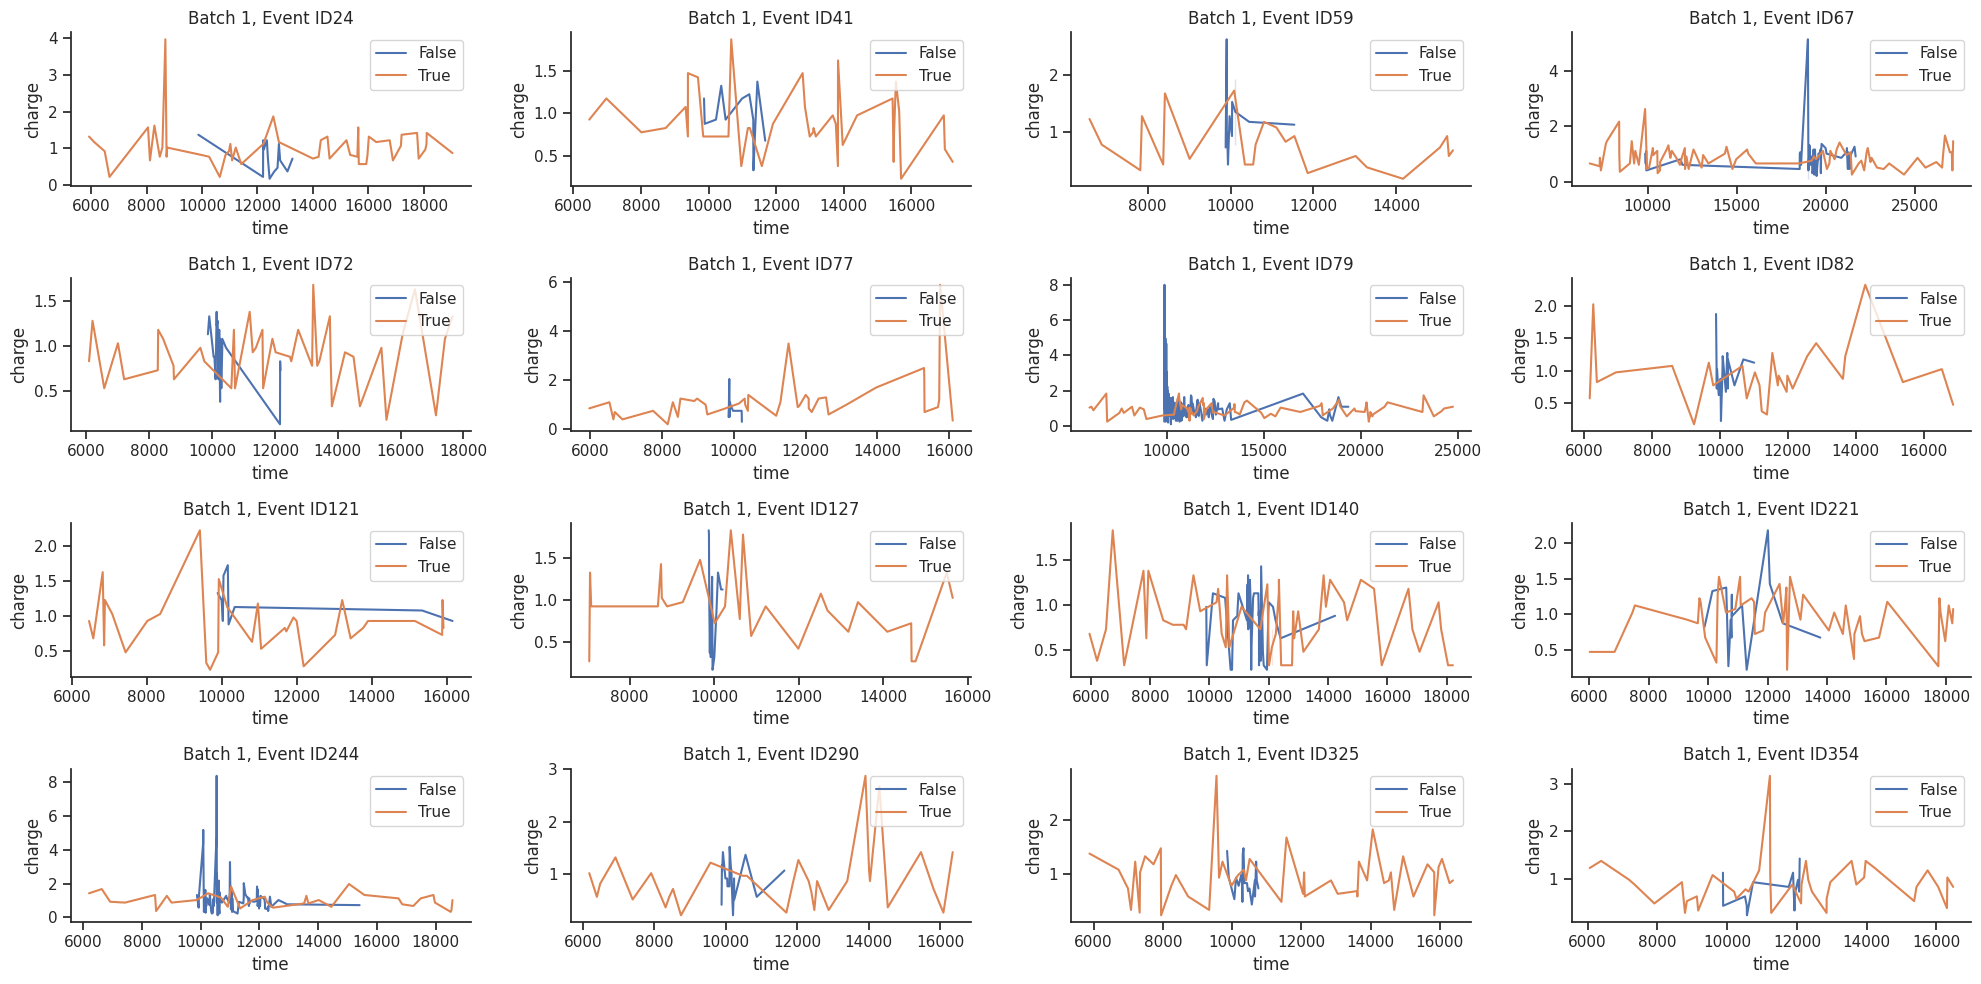

In [7]:
plt.figure(figsize = (20,10))
sns.set(font_scale = 1,style = 'ticks')
for i in range(16):
    plt.subplot(4,4,i+1)
    df = sensor_info_df[(sensor_info_df.event_id==sensor_info_df.event_id.unique()[i])]
    sns.lineplot(data = df,x = 'time',y = 'charge',hue = 'auxiliary',)
    plt.title('Batch 1, Event ID'+str(sensor_info_df.event_id.unique()[i]))
    plt.legend(loc = 'upper right')
    sns.despine()
plt.tight_layout()

In [8]:
def process_tabular(df_selected):
    '''
    Processing input tensor.
    Input Tensor : 3D Tensor
    With time, batch_id, charge.
    '''
    torch_tensor = torch.tensor(df_selected.astype(int).values)
    torch_tensor_tf = torch_tensor.unsqueeze(-1)
    torch_tensor_tf = torch_tensor_tf.type(torch.LongTensor)
    torch_tensor_tf = torch_tensor_tf.permute(1,2,0)
    torch_tensor_tf = torch_tensor_tf.float()
    return(torch_tensor_tf)

In [9]:
from torch.utils.data import Dataset, DataLoader

class ICECUDE_Dataset(Dataset):
    def __init__(self, parquetfile, batch_dir, batch_num,mode='Train'):
        self.batch_num = batch_num
        self.train_meta = pq.read_table(parquetfile,filters=[('batch_id','==',self.batch_num)]).to_pandas().reset_index(drop = True)
        # Appending only HQS
        self.sensor_info_df = pq.read_table(batch_dir+'batch_'+str(batch_num)+'.parquet',filters=[('auxiliary','==',False)]).to_pandas()
        self.sensor_info_df = self.sensor_info_df.drop('auxiliary',axis=1).reset_index()
        self.dataset_mode = mode
    def __len__(self):
        return self.sensor_info_df.event_id.nunique()

    def __getitem__(self, idx):
        '''
        Tensors will be iterated using event_id, in DataLoader.
        Since Parquet batch files are quite large, parquet files of interest loaded in __init__ function.
        And then generate input tensors using event_id as an index.
        '''
        event_id = self.sensor_info_df.event_id.unique()
        sensor_info_df_tmp = self.sensor_info_df
        sensor_info_df_tmp = sensor_info_df_tmp[sensor_info_df_tmp.event_id==event_id[idx]].drop('event_id',axis=1)
        train_meta_tmp = self.train_meta[self.train_meta.event_id==event_id[idx]]
        input_tensor = process_tabular(sensor_info_df_tmp)
        if self.dataset_mode=='Train':
            label = torch.Tensor(train_meta_tmp[['azimuth','zenith']].values).squeeze()
            sample = {'input_tensor': input_tensor,'label':label}
        else :
            sample = {'input_tensor':input_tensor}
        return sample


In [10]:
# 기본 ResNet 34층
def resnet34(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress, **kwargs)

# 기본 ResNet 50층
def resnet50(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)

# Wide ResNet
def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)

# ResNext
def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    kwargs['groups'] = 32 # input channel을 32개의 그룹으로 분할 (cardinality)
    kwargs['width_per_group'] = 4 # 각 그룹당 4(=128/32)개의 채널으로 구성.
    # 각 그룹당 channel 4의 output feautre map 생성, concatenate해서 128개로 다시 생성.

    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    r"""
    - pretrained: pretrained된 모델 가중치를 불러오기 (saved by caffe)
    - arch: ResNet모델 이름
    - block: 어떤 block 형태 사용할지 ("Basic or Bottleneck")
    - layers: 해당 block이 몇번 사용되는지를 list형태로 넘겨주는 부분
    """
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    r"""
    3x3 convolution with padding
    - in_planes: in_channels
    - out_channels: out_channels
    - bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정.
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        r"""
         - inplanes: input channel size
         - planes: output channel size
         - groups, base_width: ResNext나 Wide ResNet의 경우 사용
        """
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        # Basic Block의 구조
        self.conv1 = conv3x3(inplanes, planes, stride)  # conv1에서 downsample
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)

        # identity mapping시 identity mapping후 ReLU를 적용합니다.
        # 그 이유는, ReLU를 통과하면 양의 값만 남기 때문에 Residual의 의미가 제대로 유지되지 않기 때문입니다.
        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # ResNext나 WideResNet의 경우 사용
        width = int(planes * (base_width / 64.)) * groups

        # Bottleneck Block의 구조
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # default values
        self.inplanes = 64 # input feature map
        self.dilation = 1
        # stride를 dilation으로 대체할지 선택
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        r"""
        - 처음 입력에 적용되는 self.conv1과 self.bn1, self.relu는 모든 ResNet에서 동일
        - 3: 입력으로 RGB 이미지를 사용하기 때문에 convolution layer에 들어오는 input의 channel 수는 3
        """
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        r"""
        - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        - self.fc: 이후 fc layer를 연결
        """
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        r"""
        convolution layer 생성 함수
        - block: block종류 지정
        - planes: feature map size (input shape)
        - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        - stride와 dilate은 고정
        """
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1

        # the number of filters is doubled: self.inplanes와 planes 사이즈를 맞춰주기 위한 projection shortcut
        # the feature map size is halved: stride=2로 downsampling
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # 블록 내 시작 layer, downsampling 필요
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # inplanes 업데이트
        # 동일 블록 반복
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [11]:
import torch.nn as nn
model = resnet34(pretrained = False)
model.fc = nn.Sequential(nn.ReLU(),nn.Linear(in_features=512, out_features=2)) # Changed FC layer for our task

In [12]:
def collate_fn(batch):
    '''
    Resize 3D Tensors to the biggest tensor in a single batch.
    This code would resize all tensors in each batch to the tensor which have largest size (w*h).
    This collate function is applied for batch training, which requires same size of inputs to be feeded.
    '''

    # Find the largest width and height in the batch
    max_width = max(dat['input_tensor'].shape[2] for dat in batch)
    max_height = max(dat['input_tensor'].shape[1] for dat in batch)
    channels = max(dat['input_tensor'].shape[0] for dat in batch)

    resized_batch = []
    for dat in batch:
        tensor = dat['input_tensor']
        resized_tensor = torch.zeros((tensor.shape[0], max_height, max_width), dtype=tensor.dtype)
        resized_tensor[:, :tensor.shape[1], :tensor.shape[2]] = tensor
        resized_batch.append(resized_tensor)

    labels = [tensor['label'] for tensor in batch]

    labels = torch.stack(labels).squeeze(-1)
    resized_batch = torch.stack(resized_batch)

    samples = {'input_tensor' : resized_batch, 'label':labels}

    return samples

In [13]:
from sklearn.metrics import mean_squared_error

def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float).to(device) # Tensor for prediction value appending
    actual = torch.tensor([], dtype=torch.float).to(device) # Tensor for answer value appending
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, values = data['input_tensor'].float().to(device),data['label'].to(device)
            outputs = model(inputs).to(device)
            predictions = torch.cat((predictions, torch.stack([torch.argmax(o) for o in outputs])),0)
            actual = torch.cat((actual, values), 0)
    predictions = predictions.cpu().numpy()
    actual = actual.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    return rmse

In [14]:
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


pqfile = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train_meta.parquet'
path_batch = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train_2/'

batch_num=1 # There are 660 batches total, and the batch number should be iterated in range(660).
lr = 1e-06
num_epochs = 1
batch_size = 8

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.BCEWithLogitsLoss().to(device)

In [15]:
ice_dataset = ICECUDE_Dataset(pqfile,path_batch,batch_num)
proportions = [.75, .10, .15]
lengths = [int(p * len(ice_dataset)) for p in proportions]
lengths[-1] = len(ice_dataset) - sum(lengths[:-1])
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(ice_dataset, lengths)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn, num_workers=11)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn, num_workers=11)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn, num_workers=11)

In [16]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_dataloader,
    'val_dataloader': val_dataloader,
    'test_dataloader': test_dataloader,
    'device':device,
    'num_epoch' : num_epochs
}


In [17]:
train_dataset[0]['input_tensor'].shape

torch.Size([3, 1, 70])

In [18]:
train_dataset[0]['label'] # This would be 'azimuth','zenith'

tensor([2.9155, 1.7699])

In [19]:
def train(model, params):
    model.train()
    loss_function=params["loss_function"]
    train_dataloader=params["train_dataloader"]
    val_dataloader=params["val_dataloader"]
    test_dataloader=params["test_dataloader"]

    device=params["device"]
    for epoch in range(0, num_epochs):
        with tqdm(train_dataloader,unit = 'batch') as tepoch:
            for dat in train_dataloader:
                tepoch.set_description(f"Epoch {epoch}")
                inputs, labels = dat['input_tensor'].to(device),dat['label'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs).to(device)
                train_loss = loss_function(outputs.float(),labels.float())
                train_loss = train_loss.requires_grad_(True)
                train_loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=train_loss.item())

    model.eval()
    train_rmse = evaluation(train_dataloader)
    val_rmse = evaluation(val_dataloader)

    print(" Train Loss: %.4f, Validation Loss: %.4f" %(train_rmse, val_rmse))
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    return(0)


train(model, params)

Epoch 0:   0%|          | 0/18750 [23:06<?, ?batch/s, loss=-15.1]   


KeyboardInterrupt: 

In [ ]:
pqfile = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/test_meta.parquet'
path_batch = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/test/'
batch_num=661
inference_dataset = ICECUDE_Dataset(pqfile,path_batch,batch_num,'test')
inference_dataloader = DataLoader(inference_dataset, batch_size=1)

In [ ]:
model.eval()
output_lst=[]
for dat in inference_dataloader:
    inputs = dat['input_tensor'].to(device)
    outputs = model(inputs).to(device)
    outputs = outputs.cpu().detach().squeeze().numpy()
    outputs = outputs.tolist()
    output_lst.append(outputs)

In [ ]:
sample_sub = pq.read_table('/kaggle/input/icecube-neutrinos-in-deep-ice/sample_submission.parquet').to_pandas()
batch661 = pq.read_table('/kaggle/input/icecube-neutrinos-in-deep-ice/test/batch_661.parquet').to_pandas()


In [ ]:
sample_sub

In [ ]:
submission = pd.DataFrame(output_lst)
submission.index = batch661.index.unique().tolist()
submission.reset_index(inplace = True)
submission.columns = ['event_id','azimuth','zenith']

In [ ]:
submission